Type I Equilibrium Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from scipy.integrate import solve_ivp
from sim_graph_funs import *
from scipy.optimize import fsolve, minimize, root
figureops = dict(bbox_inches = 'tight', dpi = 600)

In [10]:
H=0
x_max = 10
params_base = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

# Example Iteration

In [3]:
P0 = 3
xvec = np.arange(1,11,1)
F0 = np.zeros(x_max) + P0/x_max
F0 = F0/xvec

params = params_base.copy()
out2 = solve_ivp(full_model, [0, 2000], [P0,0.5,0.4, *F0], method="LSODA",
                args=(True,params))

2000.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$T$, Scaled time', ylabel='$xF(x)/P$'>)

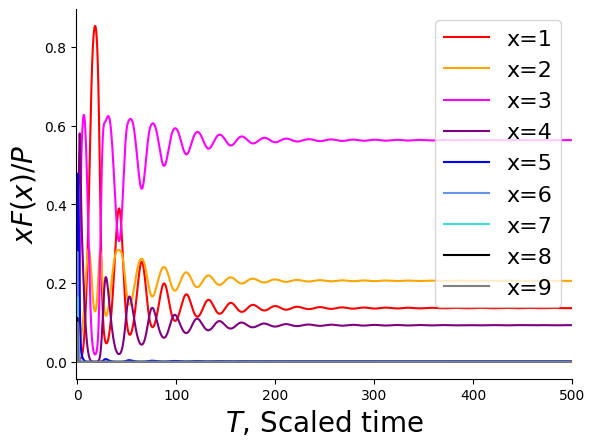

In [4]:
fig, ax = plt.subplots(1,1)
plot_portion_x(fig, ax, out2, x_max=10, xlim = [-1,500])

# Solve for Equilibria

In [5]:
# given paramvec, paramkey, x_max, params

def get_equilibria_vary_param(paramvec, paramkey, x_max, **params):
    '''
    Get a list of equilibrium values corresponding to the parameters
    '''

    def iterate_to_eq(initialstate, t_f,params):
        '''
        try to iterate to eq in t_f time steps
        '''
        out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                    args=(True,params))
        T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)
        full_trajectory = T,N1,N2,P,Fxvec, mean_x
        N1,N2,P,mean_x = [ item[-1] for item in [N1,N2,P,mean_x]]
        F = Fxvec[:,-1]
        timederivatives = full_model(T[-1], [P,N1,N2,*F],True,params)
        success = np.any(np.array(timederivatives)<1e-8)
        
        return np.array([P, N1, N2, *F]), success, mean_x, full_trajectory




    xvec = np.arange(1,x_max+1,1)
    Pvec = np.zeros(len(paramvec))
    meanxvec = np.zeros(len(paramvec))
    Fxvecs  = np.zeros((len(paramvec), x_max))
    N1vec = Pvec.copy()
    N2vec = Pvec.copy()
    success_vec = Pvec.copy()
    stability_vec = Pvec.copy()
    
    for i, param in enumerate(paramvec):
        params = params_base.copy()
        params[paramkey] = param
        out_eq = iterate_and_solve_equilibrium(params, t_f = 5)
        P, N1, N2, F, mean_x, success = out_eq
        if success==False:
            t_f = 200
            initialstate = [3,0.5,0.4, 1, *np.zeros(x_max-1)]
            finalpoint, success, mean_x, full_trajectory = iterate_to_eq(initialstate, t_f,
                                                                         params)
            if success == False:
                out = iterate_to_eq(finalpoint, 2000,params)   
                finalpoint, success, mean_x, full_trajectory = out

            P,N1,N2 = finalpoint[0:3]
            F = finalpoint[3:]
        success_vec[i] = success
        
        Fxvecs[i,:] = F
        Pvec[i] = P
        N1vec[i] = N1
        N2vec[i] = N2
        meanxvec[i] = mean_x
        try:
            if np.any(np.isnan(np.array([P,N1,N2,*F]))):
                stability_vec[i] = np.nan
        except TypeError:
            stability_vec[i] = np.nan
        else:
            J = fun_Jac(N1,N2,np.array(F),**params)
            stability = classify_stability(J)
            if stability == "Stable (attractive)":
                stability_vec[i] = 1
            elif stability == "Unstable":
                stability_vec[i] = -1
            else:
                stability_vec[i] = 0
        
    return Pvec, N1vec, N2vec, Fxvecs,meanxvec,success_vec, stability_vec


    

In [6]:
β1vec = np.arange(1,10,0.2)
paramvec = β1vec
paramkey = 'β1'
out = get_equilibria_vary_param(paramvec, paramkey, **params_base.copy())
Pvec, N1vec, N2vec, Fxvecs,meanxvec,success_vec, stability_vec = out

In [7]:
stability_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

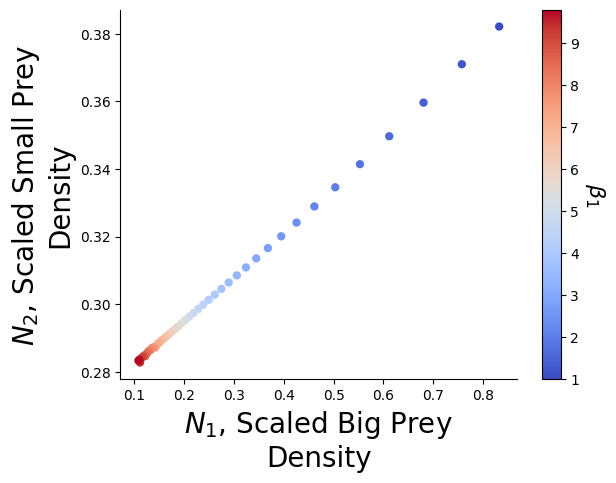

In [8]:
fig, ax = plt.subplots(1,1)
mask = stability_vec == 1
p = plt.scatter(N1vec[mask],N2vec[mask], c = β1vec[mask], cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\beta_1$', ylabel='Freq$(x)$'>)

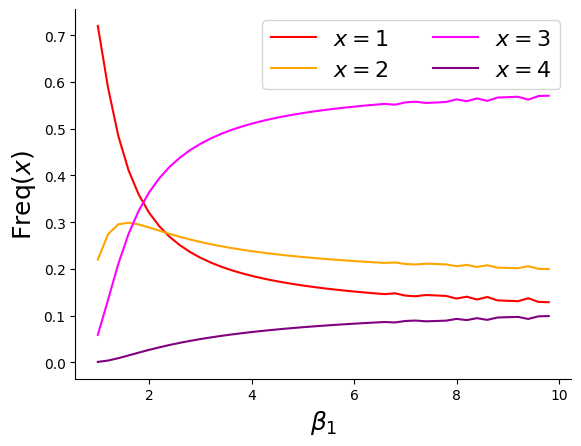

In [10]:
freq_x_lab = r'Freq$(x)$'
fig, ax = plot_freq_x_eq(β1vec, Fxvecs, xvec, Pvec, β1lab, 
                       ncol_legend = 2,
                       )

# Get Equilibria through iterating

In [3]:
xvec = np.arange(1,x_max+1,1)
β1vec = np.arange(1,10,0.2)
Pvec = np.zeros(len(β1vec))
meanxvec = np.zeros(len(β1vec))
Fxvecs  = np.zeros((len(β1vec), x_max))
N1vec = Pvec.copy()
N2vec = Pvec.copy()

for i, β1 in enumerate(β1vec):
    params = params_base.copy()
    params['β1'] = β1
    initialstate = np.array([3, 0.5, 0.5, 3, *np.zeros(9)])
    t_f = 2000
    out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
    T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)
    #N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)
    Fxvecs[i,:] = Fxvec[:,-1]
    Pvec[i] = P[-1]
    N1vec[i] = N1[-1]
    N2vec[i] = N2[-1]
    meanxvec[i] = mean_x[-1]
    

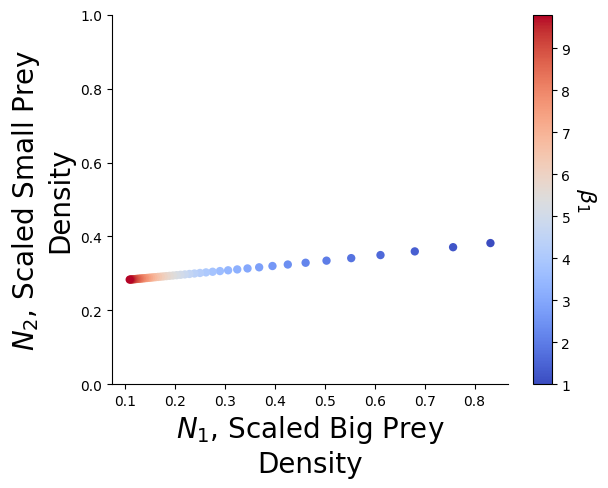

In [20]:
fig, ax = plt.subplots(1,1)
p = plt.scatter(N1vec,N2vec, c = β1vec[mask], cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab, ylim = [0,1])
fig.savefig(final_fig_path + 'Full_Dyn_beta1_vs_prey.png', **figureops)

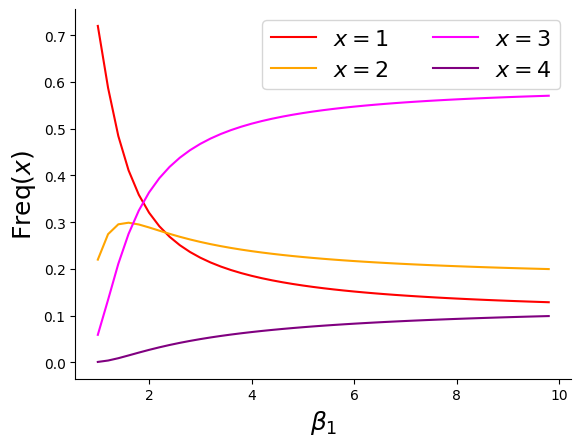

In [15]:
freq_x_lab = r'Freq$(x)$'
fig, ax = plot_freq_x_eq(β1vec, Fxvecs, xvec, Pvec, β1lab, 
                       ncol_legend = 2,
                       )
fig.savefig(final_fig_path + 'Full_Dyn_beta1_vs_x.png', **figureops)

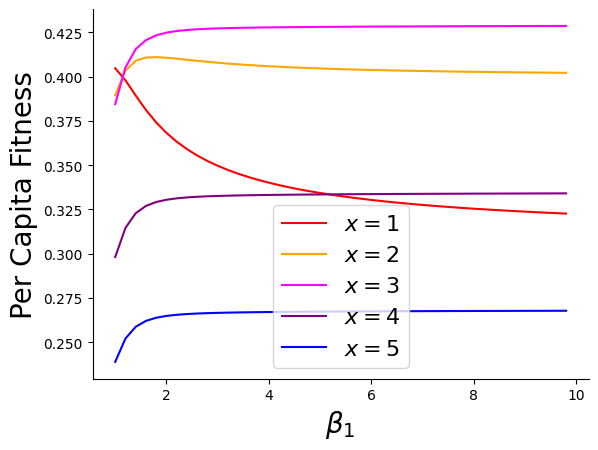

In [19]:
β1vec = np.arange(1,10,0.2)
fig,ax = plt.subplots(1,1)
for x in range(1,6):
    Wx = []
    for N1,N2,β1 in zip(N1vec, N2vec, β1vec):
        params = params_base.copy()
        params['β1'] = β1
        Wx.append( per_capita_fitness_from_prey_non_dim(x, N1, N2, **params))
    ax.plot(β1vec,Wx,colors[x-1], label = r'$x = $'+'%d'%x)
    
format_ax(ax, β1lab, 'Per Capita Fitness', if_legend = True, ncol_legend=1)
fig.savefig(final_fig_path + 'Full_Dyn_beta1_vs_fitness_x.png', **figureops)

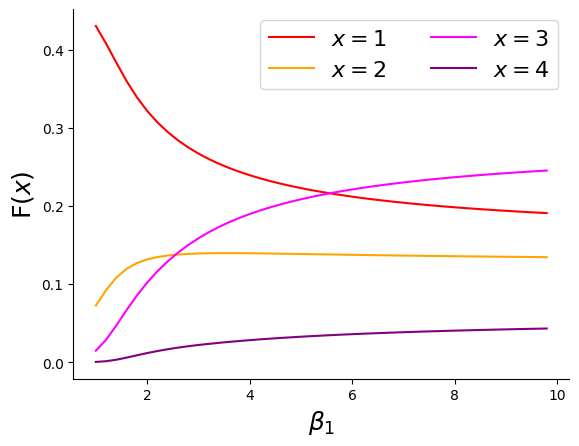

In [13]:
fig,ax = plot_F_equilibrium(β1vec, Fxvecs, xvec, β1lab, Fxlab, ncol_legend=2)

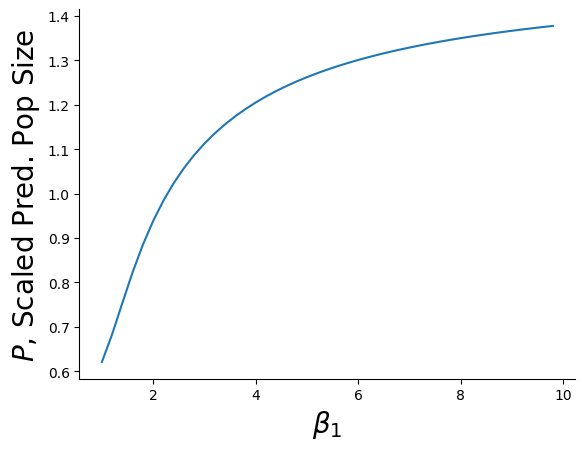

In [17]:
fig,ax = plt.subplots(1,1)
plt.plot(β1vec, Pvec)
format_ax(ax,β1lab,Plab)

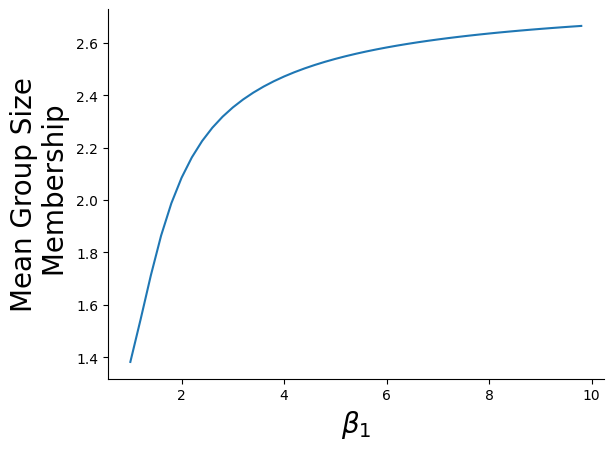

In [18]:
fig,ax = plt.subplots(1,1)
plt.plot(β1vec, meanxvec)
format_ax(ax,β1lab,mean_x_lab)